In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = [10, 50]
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_agents = num_packages = 200
num_fcs = 50

filename = "local_ap_N%s_%.2f_n%d_m%d"%(",".join(list(map(str, num_points))), eps_sublevel, num_agents, num_fcs)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  integer=False)
print(f"{true_f=}")

true_f=-90.29596235198767


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028331876

In [7]:
true_lamb.shape, true_xp.size + true_xf.size

((50,), 10050)

In [8]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_packages):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                  econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                  econ, percent=percent, K=K, return_best=True)]
 
for i in range(num_packages, num_packages+num_fcs):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                          econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                          econ, percent=percent, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for K_i in num_points:
    print(f"{K_i=}")
    all_results_eps[K_i]  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[K_i]  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

K_i=10


/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.0444E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=15, f_subopt_xk=2.1195E-02,  f_subopt_mra=4.3802E-02,  viol_xk=7.8628E+01, viol_mra=8.7045E-10, lamb_rel_diff=5.8851E-02
terminate with lamb_rel_diff=0.05885063123796142
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.2548E+00,  viol_xk=1.3706E+02, viol_mra=1.3256E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5051E-03,  f_subopt_mra=8.7981E-03,  viol_xk=7.1921E+01, viol_mra=9.7300E+00, lamb_rel_diff=5.4798E-02
epoch=71, f_subopt_xk=9.4848E-03,  f_subopt_mra=8.8010E-03,  viol_xk=6.2050E+01, viol_mra=1.1497E-10, lamb_rel_diff=4.7269E-02
terminate with lamb_rel_diff=0.047268737386429234
K_i=50
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.0444E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=11, f_subopt_xk=2.3392E-02,  f_subopt_mra=4.0098E-02,  viol_xk=7.0076E+01, viol_mra=9.9037E-10, lamb_rel_diff=6.2039E-02
terminate with lamb_rel_diff=

In [11]:
K_i = min(num_points)
if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
    all_res = all_results_noisy_y[K_i]
else:
    all_res = all_results_eps[K_i]

In [12]:
for i, K_i in enumerate(num_points):
      print(np.array(all_res["viol_primal_xk"])[-1]  ,
      "sub_eps", np.array(all_results_eps[K_i]["viol_primal_mra_xk"])[-1]  ,
      "noisy_y", np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"])[-1]  )

29.175003271109873 sub_eps 5.588956519808619e-10 noisy_y 7.244066457801068e-11
29.175003271109873 sub_eps 6.383871764548132e-10 noisy_y 3.1041158532474356e-10


In [14]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle


with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    K_i = min(num_points)
    if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
        all_res = all_results_noisy_y[K_i]
    else:
        all_res = all_results_eps[K_i]
# res["eps"].keys()

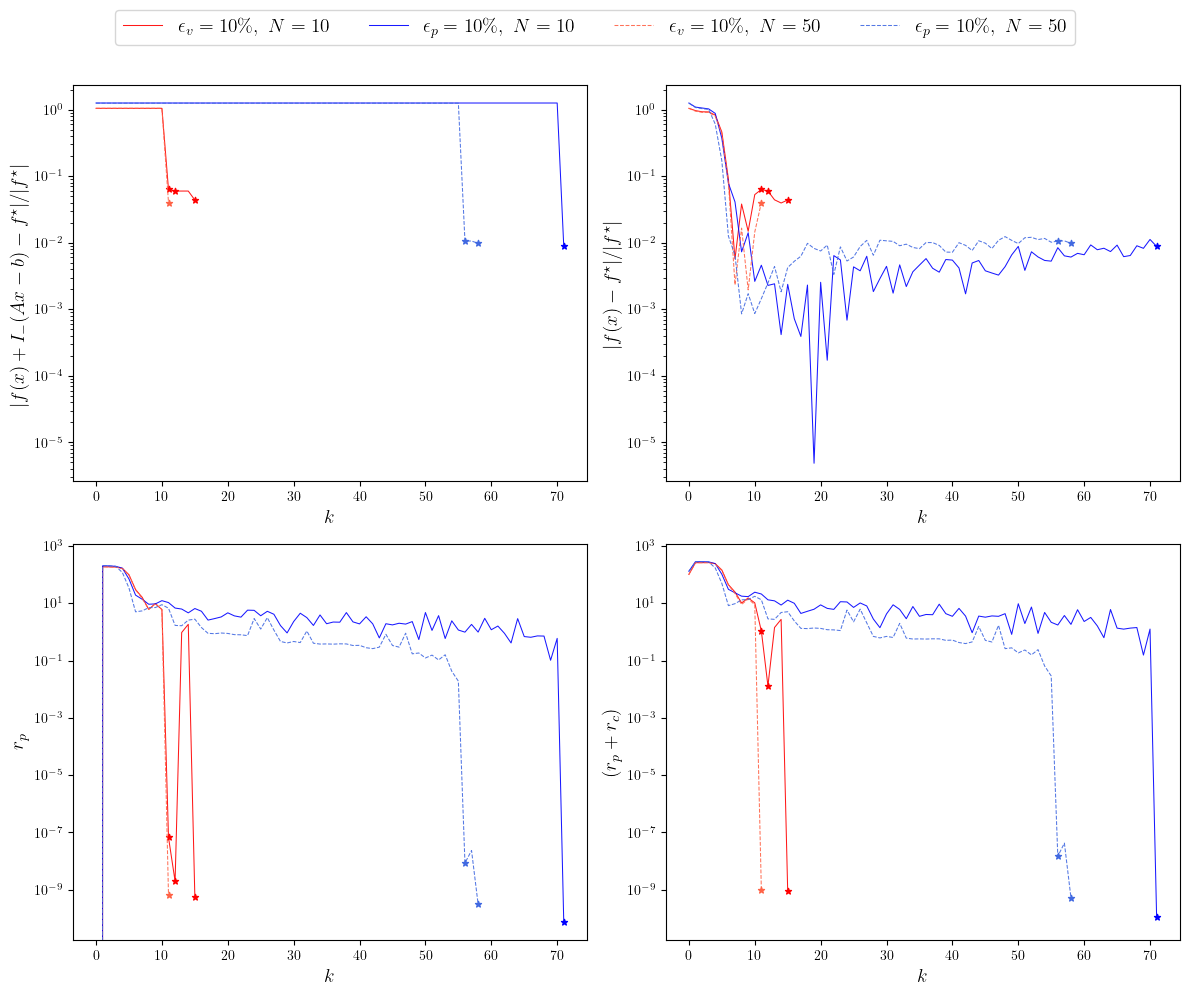

In [7]:
mra.plot_N_all_metrics_4x(all_results_eps, all_results_noisy_y, eps_sublevel, true_f, 
                                b_norm, num_points, filename)

In [9]:
for K_i in num_points:
    print(f"{K_i=}")
    eps_subopt = (np.abs(np.array(all_results_eps[K_i]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[K_i]["viol_primal_mra_xk"]) 
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[K_i]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"]) 

    res_tol = 1e-6
    first_eps   = next((i for i,x in enumerate(eps_res)   if x < res_tol), None)
    first_noisy = next((i for i,x in enumerate(noisy_y_res) if x < res_tol), None)
    print(f"eps → {first_eps}, noisy → {first_noisy}")

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[K_i], true_f, 1),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[K_i], true_f, 1),)

    print(f"eps {eps_subopt[-1]*100}\%  noisy_y {noisy_y_subopt[-1]*100}\%")

K_i=10
eps → 0, noisy → 0
eps 4.380207425851541\%  noisy_y 0.8801012707266501\%
K_i=50
eps → 0, noisy → 0
eps 4.009845058372933\%  noisy_y 0.9797661688210011\%
